This notebook is used to generate stats and figures for the 2024-03-22 meeting with the Memento staff.
It contains : summary population statistics, BOLD and parcellation signals representations, atlas plot

In [4]:
from init_nb import init_notebook
config = init_notebook()

import pandas as pd
from pathlib import Path
import joblib

from bold_dementia.data.memento import Memento
from bold_dementia.connectivity.atlases import Atlas

BIDSDIR = Path(config["bids_dir"])

dd = Path(config["data_dir"])
#ORIG_PATH = dd / "phenotypes.tsv"
#SUITE_PATH = dd / "data_memento_suite.txt"

#PPATH = Path(config["suite_phenotypes"])

ppath = Path(config["data_dir"]) / "merged_phenotypes.csv"
memento = Memento(
        BIDSDIR,
        ppath,
        atlas=Atlas.from_name("gillig", False),
    )
phenotypes = Memento.load_phenotypes(ppath)

In [5]:
#tested_pop = Path(
#    '/bigdata/jlegrand/data/Memento/output/statresults/atlas-gillig-regions_default_ols-cenanom-block/tested_population.csv',
#    )
#df = pd.read_csv(tested_pop, index_col=0)
df = memento.rest_dataset.groupby("sub").sample(n=1)
df["converter"] = (~df.DEMENCE_DAT.isna())
n = len(df["NUM_ID"].unique())
n_converter = df.converter.sum()

print(f"n unique subjects = {n}")
print(f"n_converters = {n_converter}")
print(f"n_control = {n - n_converter}")

n unique subjects = 1430
n_converters = 205
n_control = 1225


## Descriptive stats

### Subjects

In [6]:
n_missing = len(phenotypes["NUM_ID"].unique()) - len(df["NUM_ID"].unique())
print(f"{n_missing} subjects dropped when joining with scans")

182 subjects dropped when joining with scans


In [7]:
df[">=BAC"] = (df.NIVETUD.isin([">BAC", "BEP, CAP, BAC"]))
cols = ["AGE_CONS", "SEX", ">=BAC", "converter"]
desc = df.loc[:, cols].describe(include="all")
desc.loc['percentage', :] = (desc.loc["freq", :] / len(df)) * 100
desc

,AGE_CONS,SEX,>=BAC,converter
count,1430.000000,1430,1430,1430
unique,NaN,2,2,2
top,NaN,Féminin,True,False
freq,NaN,902,1093,1225
mean,71.046713,NaN,NaN,NaN
std,8.606881,NaN,NaN,NaN
min,34.500000,NaN,NaN,NaN
25%,65.800000,NaN,NaN,NaN
50%,72.000000,NaN,NaN,NaN
75%,77.300000,NaN,NaN,NaN


In [8]:
groupdesc = df.loc[:, cols].groupby("converter").describe(include="all").loc[:, ">=BAC"]
groupdesc.loc[:, "percentage"] = (groupdesc.loc[:, "freq"] / groupdesc.loc[:, "count"]) * 100
groupdesc

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,percentage
converter,,,,,,,,,,,,
False,1225,2,True,951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.632653
True,205,2,True,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.268293


In [9]:
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
import numpy as np
msk = (~df.DEMENCE_DAT.isna()) & (df.MA == 0)
testset = df[~msk]
testset.loc[:,"converter"] = np.where(testset.DEMENCE_DAT.isna(), 0, 1)
#model = Logit.from_formula("converter ~ scale(AGE_CONS) + C(SEX) + NIVETUD", data=testset)
model = Logit.from_formula(
    "converter ~ scale(AGE_CONS) + C(SEX, Treatment(reference='Masculin')) + Q('>=BAC')",
    data=testset
)
res = model.fit(maxiter=500)
print("Parameters: ", res.params)

Optimization terminated successfully.
         Current function value: 0.346138
         Iterations 7
Parameters:  Intercept                                            -1.585322
C(SEX, Treatment(reference='Masculin'))[T.Féminin]   -0.386430
Q('>=BAC')[T.True]                                   -0.408826
scale(AGE_CONS)                                       0.515392
dtype: float64


In [10]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converter   No. Observations:                 1388
Model:                          Logit   Df Residuals:                     1384
Method:                           MLE   Df Model:                            3
Date:                Mon, 25 Mar 2024   Pseudo R-squ.:                 0.04325
Time:                        13:05:23   Log-Likelihood:                -480.44
converged:                       True   LL-Null:                       -502.16
Covariance Type:            nonrobust   LLR p-value:                 1.993e-09
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             -1.5853      0.203     -7.812      0.000      -1.983      -1.188
C(SEX, Treatment(reference='Masculin'))[T.Féminin]    -0.3864      0.173     -2.229      0.026      -0.726      -0.047
Q('>=BAC')[T.True]                                    -0.4088      0.189     -2.166      0.030      -0.779      -0.039
scale(AGE_CONS)                                        0.5154      0.098      5.262      0.000       0.323       0.707
======================================================================================================================
"""

In [11]:
res.pvalues # TODO Check residuals

Intercept                                             5.613472e-15
C(SEX, Treatment(reference='Masculin'))[T.Féminin]    2.584281e-02
Q('>=BAC')[T.True]                                    3.029766e-02
scale(AGE_CONS)                                       1.423015e-07
dtype: float64

### Scans

In [12]:
rd = memento.rest_dataset
msk = ~rd.DEMENCE_DAT.isna()
rd = rd[msk]

# Be careful to use existing rows and not the row information
# which comes from naive phenotypes
for timestep in ("M000", "M024", "M048"):
    sesdf = rd[rd.ses == timestep]
    
    converted = (sesdf.loc[:, timestep] >= sesdf.DEMENCE_DAT)
    n_converted = len(sesdf[converted]["sub"].unique())
    
    has_scan = ~sesdf.loc[:, timestep].isna()
    n_scans = len(sesdf[has_scan]["sub"].unique())
    
    prop_converted = n_converted/n_scans * 100
    
    print(f"{timestep} : {n_scans} scans, {n_converted} ({prop_converted:.2f}%) converted")

print(len(memento.rest_dataset[msk]))


M000 : 173 scans, 11 (6.36%) converted
M024 : 143 scans, 58 (40.56%) converted
M048 : 72 scans, 57 (79.17%) converted
389


In [13]:
173 + 143 + 72

388

In [14]:
1061 + 791 + 683

2535

In [15]:
df[df.M000.isna()]

,file_path,file_basename,file_tag,file_type,file_fields,sub,ses,task,space,res,...,APOE_eps4,APOE_geno,APOE_y,M000,M024,M048,current_scan_age,scan_to_onset,converter,>=BAC
363,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0368_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0368,M024,rest,MNI152NLin6Asym,2,...,1.0,eps3/eps4,Oui,NaT,2016-08-26,NaT,88.469863,NaN,False,False
562,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0545_ses-M048_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0545,M048,rest,MNI152NLin6Asym,2,...,0.0,eps3/eps3,Non,NaT,2014-10-22,2016-11-23,76.084932,NaN,False,True
627,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0617_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0617,M024,rest,MNI152NLin6Asym,2,...,0.0,eps3/eps3,Non,NaT,2015-09-23,NaT,57.947945,NaN,False,False
899,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0919_ses-M048_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0919,M048,rest,MNI152NLin6Asym,2,...,1.0,eps3/eps4,Oui,NaT,2015-06-22,2017-10-05,79.476712,NaN,False,True
1011,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-1006_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",1006,M024,rest,MNI152NLin6Asym,2,...,0.0,eps3/eps3,Non,NaT,2015-05-26,NaT,64.461644,NaN,False,True
1014,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-1008_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",1008,M024,rest,MNI152NLin6Asym,2,...,0.0,eps3/eps3,Non,NaT,2016-04-11,2018-01-29,78.020548,NaN,False,True
1044,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-1023_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",1023,M024,rest,MNI152NLin6Asym,2,...,0.0,eps3/eps3,Non,NaT,2016-01-11,2017-06-26,68.701370,NaN,False,True
1662,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-1496_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",1496,M024,rest,MNI152NLin6Asym,2,...,0.0,eps3/eps3,Non,NaT,2014-09-30,2016-10-28,76.823288,NaN,False,False
2118,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-1855_ses-M048_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",1855,M048,rest,MNI152NLin6Asym,2,...,0.0,eps3/eps3,Non,NaT,2014-12-30,2016-10-28,75.794521,NaN,False,True
2207,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-1908_ses-M048_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",1908,M048,rest,MNI152NLin6Asym,2,...,0.0,eps2/eps3,Non,NaT,NaT,2016-09-27,44.384932,NaN,False,True


In [16]:
173 + 143 + 72

388

In [17]:
df[~df.DEMENCE_DAT.isna()]

,file_path,file_basename,file_tag,file_type,file_fields,sub,ses,task,space,res,...,APOE_eps4,APOE_geno,APOE_y,M000,M024,M048,current_scan_age,scan_to_onset,converter,>=BAC
18,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0026_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0026,M024,rest,MNI152NLin6Asym,2,...,0.0,eps3/eps3,Non,2011-05-23,2013-05-30,2015-05-22,83.830137,551.0,True,True
42,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0041_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0041,M000,rest,MNI152NLin6Asym,2,...,1.0,eps3/eps4,Oui,2012-04-17,2014-06-16,NaT,63.600000,1749.0,True,False
49,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0046_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0046,M000,rest,MNI152NLin6Asym,2,...,1.0,eps3/eps4,Oui,2012-10-11,2014-09-04,NaT,81.321918,693.0,True,True
67,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0071_ses-M048_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0071,M048,rest,MNI152NLin6Asym,2,...,NaN,NaN,NaN,2011-05-30,NaT,2015-04-08,71.334247,0.0,True,True
96,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0105_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0105,M000,rest,MNI152NLin6Asym,2,...,0.0,eps3/eps3,Non,2012-09-04,2014-09-08,NaT,79.900000,1637.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-2427_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",2427,M000,rest,MNI152NLin6Asym,2,...,NaN,NaN,NaN,2013-06-27,2015-06-02,NaT,80.357534,705.0,True,True
2898,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-2429_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",2429,M024,rest,MNI152NLin6Asym,2,...,1.0,eps3/eps4,Oui,NaT,2015-06-06,NaT,67.569863,23.0,True,True
2905,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-2433_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",2433,M024,rest,MNI152NLin6Asym,2,...,0.0,eps3/eps3,Non,2012-07-19,2014-07-17,NaT,84.394521,-549.0,True,True
2913,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-2441_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",2441,M000,rest,MNI152NLin6Asym,2,...,0.0,eps3/eps3,Non,2012-04-04,2014-06-10,2016-04-13,84.160274,1098.0,True,False


In [18]:
rd[msk]

/tmp/ipykernel_1217912/1486842389.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rd[msk]


,file_path,file_basename,file_tag,file_type,file_fields,sub,ses,task,space,res,...,MA,DEMENCE_DAT,APOE_eps4,APOE_geno,APOE_y,M000,M024,M048,current_scan_age,scan_to_onset
17,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0026_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0026,M000,rest,MNI152NLin6Asym,2,...,1.0,2014-12-02,0.0,eps3/eps3,Non,2011-05-23,2013-05-30,2015-05-22,81.808219,1289.0
18,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0026_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0026,M024,rest,MNI152NLin6Asym,2,...,1.0,2014-12-02,0.0,eps3/eps3,Non,2011-05-23,2013-05-30,2015-05-22,83.830137,551.0
19,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0026_ses-M048_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0026,M048,rest,MNI152NLin6Asym,2,...,1.0,2014-12-02,0.0,eps3/eps3,Non,2011-05-23,2013-05-30,2015-05-22,85.808219,-171.0
42,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0041_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0041,M000,rest,MNI152NLin6Asym,2,...,0.0,2017-01-30,1.0,eps3/eps4,Oui,2012-04-17,2014-06-16,NaT,63.600000,1749.0
43,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0041_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0041,M024,rest,MNI152NLin6Asym,2,...,0.0,2017-01-30,1.0,eps3/eps4,Oui,2012-04-17,2014-06-16,NaT,65.764384,959.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-2433_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",2433,M024,rest,MNI152NLin6Asym,2,...,1.0,2013-01-14,0.0,eps3/eps3,Non,2012-07-19,2014-07-17,NaT,84.394521,-549.0
2913,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-2441_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",2441,M000,rest,MNI152NLin6Asym,2,...,1.0,2015-04-07,0.0,eps3/eps3,Non,2012-04-04,2014-06-10,2016-04-13,84.160274,1098.0
2919,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-2447_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",2447,M000,rest,MNI152NLin6Asym,2,...,0.0,2017-11-21,1.0,eps3/eps4,Oui,2012-09-13,2014-10-29,2017-01-17,72.708219,1895.0
2920,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-2447_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",2447,M024,rest,MNI152NLin6Asym,2,...,0.0,2017-11-21,1.0,eps3/eps4,Oui,2012-09-13,2014-10-29,2017-01-17,74.834247,1119.0


In [19]:
c = (rd.M000 >= rd.DEMENCE_DAT)
len(rd[~rd.DEMENCE_DAT.isna() & c])

20

In [20]:
1061 + 791 + 683

2535

## Illustrative plots

In [21]:
from nilearn.interfaces.fmriprep import load_confounds

In [22]:
scanidx = 900
fpath = df.iloc[scanidx, 0]
fname = df.iloc[scanidx, 1]
confounds, msk = load_confounds(fpath, strategy=["motion", "wm_csf", "global_signal"], motion="basic")

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


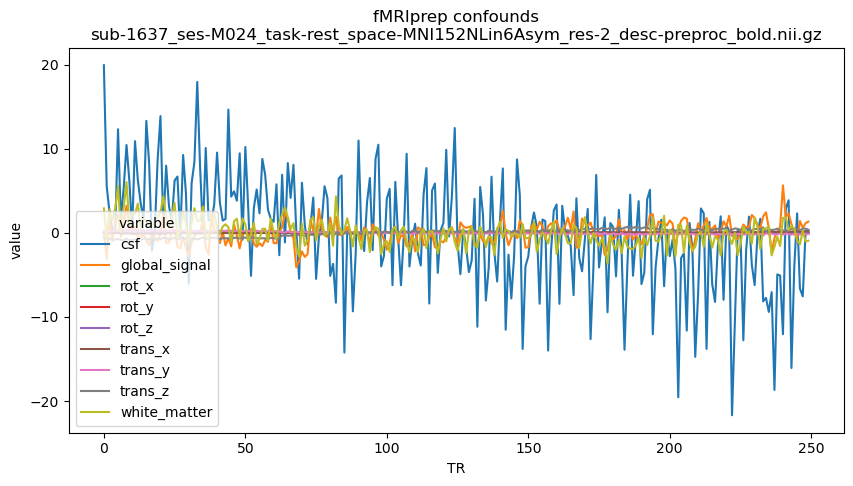

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

confounds["TR"] = list(range(len(confounds)))
m = confounds.melt(id_vars="TR")

plt.subplots(figsize=(10, 5))
sns.lineplot(m, x="TR", y="value", hue="variable")
plt.title(f"fMRIprep confounds\n{fname}")
plt.show()

In [24]:
from bold_dementia.connectivity.atlases import Atlas

atlas = Atlas.from_name("gillig", soft=False)

In [25]:
import nibabel as nib
arr = nib.load(fpath).get_fdata()

In [26]:
import joblib
ts = joblib.load("/georges/memento/BIDS/derivatives/gillig/time_series/sub-1321_ses-M000_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz")

In [27]:
arr.shape

(91, 109, 91, 250)

In [28]:
91 * 109 * 91

902629

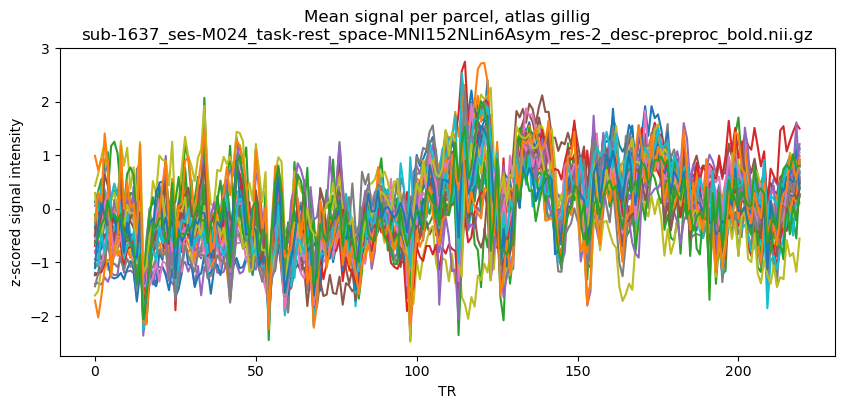

In [29]:
from scipy.stats import zscore
plt.subplots(figsize=(10, 4))
plt.plot(zscore(ts)[10:])
plt.xlabel("TR")
plt.ylabel("z-scored signal intensity")
plt.title(f"Mean signal per parcel, atlas {atlas.name}\n{fname}")
plt.show()


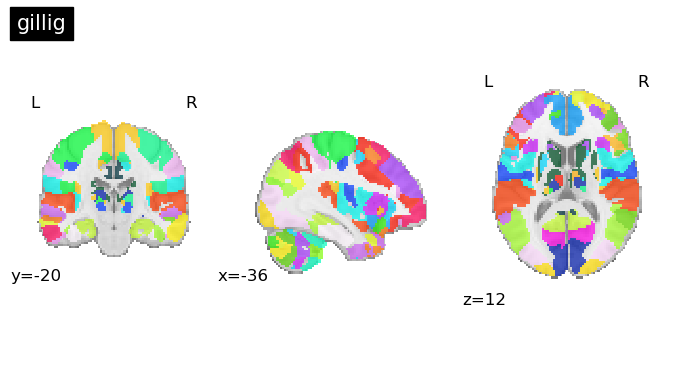

In [30]:
atlas.plot(draw_cross=False)
plt.show()

In [31]:
matrices = joblib.load("/bigdata/jlegrand/data/Memento/output/connectivity/atlas-gillig_default/control.joblib")

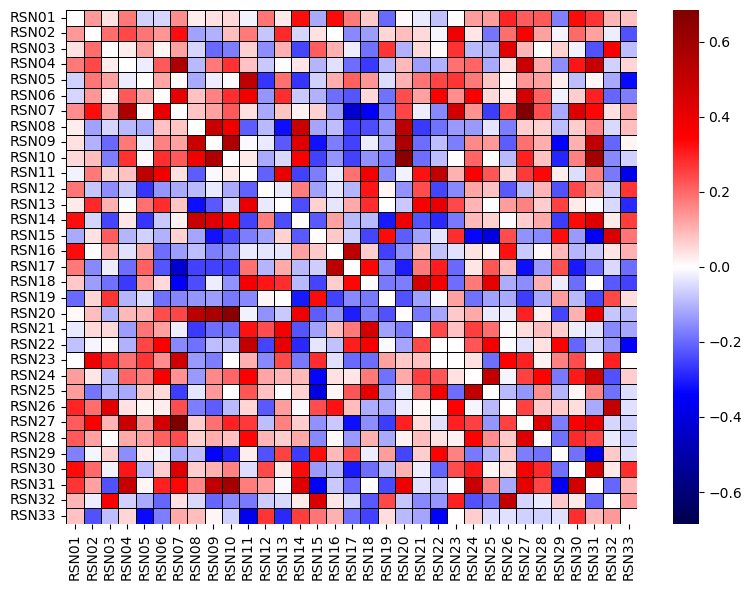

In [32]:
from bold_dementia.connectivity import plot_matrix, plot_ordered_matrix
plot_ordered_matrix(matrices[100, :, :], atlas)
plt.show()